# Assignment 2
**COMP 511: Network Science**

**Due on February 6th 2026**

In [10]:
import pandas as pd
import networkx as nx
from collections import Counter, defaultdict
import gdown
import tarfile
import os
import re
import numpy as np

## 1. Centrality Measures [20%]

Select 3 (or more) centrality measures and find the top 5 most important nodes in the [Enron dataset](https://www.cs.cornell.edu/~arb/data/pvc-email-Enron/). Who are the top ranked people?

*   aggregate all emails sent at different times into a static snapshot with an edge weight showing how many emails in total have been send from one node to the other

In [11]:
# google drive file ID
file_id = "1hbpdnqvTRqPZ4MvzxeKLLkifdXZhtQsn"

output_file = "email-Enron.tar.gz"

gdown.download(f"https://drive.google.com/uc?id={file_id}", output_file, quiet=False)

# Extract the .tar.gz file
try:
    with tarfile.open(output_file, "r:gz") as tar:
        tar.extractall()  # extract into "email-Enron" folder
        print("Extraction completed successfully.")
except tarfile.ReadError as e:
    print("Error reading the tar.gz file:", e)

Downloading...
From: https://drive.google.com/uc?id=1hbpdnqvTRqPZ4MvzxeKLLkifdXZhtQsn
To: /Users/barthelemyderivieres/Desktop/McGill/U4 sem 2/COMP511/A1/COMP-511-assignment-1/A2/email-Enron.tar.gz
100%|██████████| 1.66M/1.66M [00:00<00:00, 8.55MB/s]


Extraction completed successfully.


In [12]:
data_folder = 'email-Enron'
addresses_path = f"{data_folder}/addresses-email-Enron.txt"
core_path = f"{data_folder}/core-email-Enron.txt"
email_path = f"{data_folder}/email-Enron.txt"

# read the addresses
addresses_df = pd.read_csv(
    addresses_path,
    sep=r'\s+',
    header=None,
    names=['ID', 'email_address'],
    on_bad_lines='skip'
)
addresses_df.set_index('ID', inplace=True)

# read core ids
core_df = pd.read_csv(
    core_path,
    sep=r'\s+',
    header=None,
    names=['ID']
)

# use set for efficiency
core_ids = set(core_df['ID'].tolist())

# read email edges
edges_df = pd.read_csv(
    email_path,
    sep=r'\s+',
    header=None,
    names=['sender', 'recipient', 'timestamp']
)

# we need to aggregate the edge weights to get a static snapshot that we can use
agg_edges = edges_df.groupby(['sender', 'recipient']).size().reset_index(name='weight')

# now lets make the static graph
G_static = nx.DiGraph()

# add weights between nodes based on agg_edges
for row in agg_edges.itertuples(index=False):
    G_static.add_edge(row.sender, row.recipient, weight=row.weight)

# add the email as a node attribute so we can see important names later
for node in G_static.nodes():
  try:
    G_static.nodes[node]['email_address'] = addresses_df.loc[node, 'email_address']
  except KeyError:
    pass

In [13]:
# compute centrality measures on the full directed graph
deg_cent = nx.degree_centrality(G_static)
eig_cent = nx.eigenvector_centrality(G_static, max_iter=1000)

# for closeness and betweenness we need finite shortest paths,
# so restrict to the largest strongly connected component
scc_nodes = max(nx.strongly_connected_components(G_static), key=len)
G_scc = G_static.subgraph(scc_nodes).copy()
print(f"Largest SCC has {G_scc.number_of_nodes()} nodes (used for closeness & betweenness)")

close_cent = nx.closeness_centrality(G_scc)
betw_cent = nx.betweenness_centrality(G_scc)

# helper to look up email from node id
def node_to_email(nid):
    if nid in addresses_df.index:
        return addresses_df.loc[nid, 'email_address']
    return f"Unknown({nid})"

# display top 5 for each measure
measures = {
    'Degree': deg_cent,
    'Eigenvector': eig_cent,
    'Closeness': close_cent,
    'Betweenness': betw_cent,
}

for name, scores in measures.items():
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:5]
    print(f"\nTop 5 by {name} Centrality:")
    for i, (nid, val) in enumerate(ranked, 1):
        print(f"  {i}. {node_to_email(nid)} — {val:.5f}")

Largest SCC has 5866 nodes (used for closeness & betweenness)

Top 5 by Degree Centrality:
  1. kenneth.lay@enron.com — 0.09698
  2. sally.beck@enron.com — 0.09451
  3. jeff.dasovich@enron.com — 0.08714
  4. jeff.skilling@enron.com — 0.08160
  5. tana.jones@enron.com — 0.07407

Top 5 by Eigenvector Centrality:
  1. john.lavorato@enron.com — 0.17060
  2. tana.jones@enron.com — 0.16632
  3. louise.kitchen@enron.com — 0.16083
  4. sara.shackleton@enron.com — 0.15028
  5. greg.whalley@enron.com — 0.14863

Top 5 by Closeness Centrality:
  1. louise.kitchen@enron.com — 0.40934
  2. john.lavorato@enron.com — 0.40543
  3. mark.taylor@enron.com — 0.40487
  4. elizabeth.sager@enron.com — 0.39666
  5. tana.jones@enron.com — 0.39530

Top 5 by Betweenness Centrality:
  1. jeff.dasovich@enron.com — 0.09499
  2. sally.beck@enron.com — 0.09471
  3. tana.jones@enron.com — 0.07670
  4. sara.shackleton@enron.com — 0.07195
  5. vince.kaminski@enron.com — 0.06516


## 2. Graph Clustering [50%]

Select two (or more) community detection or graph clustering algorithms, apply them on the following real world datasets and evaluate their performances:

*   -- real-classic: [strike, karate, polblog, polbooks, football](http://www.reirab.com/Teaching/NS20/classic.tar.gz)
*   -- real-node-label: [citeseer, cora, pubmed](https://github.com/tkipf/gcn/tree/master/gcn/data)

Here, the goal is to use the classification labels as clustering labels, and see how well we can find those labels without using the feature vectors.

In [18]:
# download classic graph data
download_folder = "classic_graph_data/"
os.makedirs(download_folder, exist_ok=True)

file_ids = {
    "polbooks.gml": "1SzhpzmpEO9NSjEabjoZP16NzYN3s6RBn",
    "polbooks.txt": "1yEzPMsGPUwrGepoxN4hlX3a54CvAPLj-",
    "polblogs.gml": "10ptbBiMgm541aAr3Rd4svBFia6qjJOGV",
    "polblogs.txt": "1un9r36q4qtuz9Kjv7MqVifMp0pH45Es2",
    "karate.gml": "1zvpOcA_74qO0pp9o36xg2rdwx9pTkgW_",
    "karate.txt": "1-i66II9DThEJruAWoslgb2Cc88R17jBK",
    "strike.gml": "137lB6IHqkRzHYOeYBn-0n4pNIYN3tuvr",
    "football.gml": "1ooEj5eBI7UM2ZtfexmaTxIFJt6qn43Uy",
    "football.txt": "126uHBR218fWCBRJjORSmaaxoHUGfTbPp",
}

for file_name, file_id in file_ids.items():
    url = f"https://drive.google.com/uc?id={file_id}"
    output_path = os.path.join(download_folder, file_name)
    gdown.download(url, output_path, quiet=False)
    print(f"Downloaded: {file_name}")

# download labeled graph data
download_folder = "labeled_graph_data/"
os.makedirs(download_folder, exist_ok=True)

file_ids = {
    "citeseer_node_labels": "1u51oSH8O46i3WnG_RqHrxcZnTURod20l",
    "citeseer_edges": "1IceUHrm8fk51Fb_gLHmXg0kETcCZa2bw",
    "cora_cites": "1AC_LOmycApD7_MtahW6WeaxSOzhPPp9J",
    "cora_content": "1mQ9dWt_8jJr0pJFiyTsKS2hGEE85YPZQ",
    "pubmed_node_labels": "1HUlVeZCjiO4GEQrQgH282VPC835mfPaO",
    "pubmed_edges": "1lss1_snvRj8sx4Aoo-vS2bJt62j_3YPt"
}

for file_name, file_id in file_ids.items():
    url = f"https://drive.google.com/uc?id={file_id}"
    output_path = os.path.join(download_folder, file_name)
    gdown.download(url, output_path, quiet=False)
    print(f"Downloaded: {file_name}")

Downloading...
From: https://drive.google.com/uc?id=1SzhpzmpEO9NSjEabjoZP16NzYN3s6RBn
To: /Users/barthelemyderivieres/Desktop/McGill/U4 sem 2/COMP511/A1/COMP-511-assignment-1/A2/classic_graph_data/polbooks.gml
100%|██████████| 26.3k/26.3k [00:00<00:00, 25.7MB/s]


Downloaded: polbooks.gml


Downloading...
From: https://drive.google.com/uc?id=1yEzPMsGPUwrGepoxN4hlX3a54CvAPLj-
To: /Users/barthelemyderivieres/Desktop/McGill/U4 sem 2/COMP511/A1/COMP-511-assignment-1/A2/classic_graph_data/polbooks.txt
100%|██████████| 638/638 [00:00<00:00, 543kB/s]


Downloaded: polbooks.txt


Downloading...
From: https://drive.google.com/uc?id=10ptbBiMgm541aAr3Rd4svBFia6qjJOGV
To: /Users/barthelemyderivieres/Desktop/McGill/U4 sem 2/COMP511/A1/COMP-511-assignment-1/A2/classic_graph_data/polblogs.gml
100%|██████████| 978k/978k [00:00<00:00, 5.90MB/s]


Downloaded: polblogs.gml


Downloading...
From: https://drive.google.com/uc?id=1un9r36q4qtuz9Kjv7MqVifMp0pH45Es2
To: /Users/barthelemyderivieres/Desktop/McGill/U4 sem 2/COMP511/A1/COMP-511-assignment-1/A2/classic_graph_data/polblogs.txt
100%|██████████| 763/763 [00:00<00:00, 1.43MB/s]


Downloaded: polblogs.txt


Downloading...
From: https://drive.google.com/uc?id=1zvpOcA_74qO0pp9o36xg2rdwx9pTkgW_
To: /Users/barthelemyderivieres/Desktop/McGill/U4 sem 2/COMP511/A1/COMP-511-assignment-1/A2/classic_graph_data/karate.gml
100%|██████████| 4.31k/4.31k [00:00<00:00, 4.37MB/s]


Downloaded: karate.gml


Downloading...
From: https://drive.google.com/uc?id=1-i66II9DThEJruAWoslgb2Cc88R17jBK
To: /Users/barthelemyderivieres/Desktop/McGill/U4 sem 2/COMP511/A1/COMP-511-assignment-1/A2/classic_graph_data/karate.txt
100%|██████████| 343/343 [00:00<00:00, 670kB/s]


Downloaded: karate.txt


Downloading...
From: https://drive.google.com/uc?id=137lB6IHqkRzHYOeYBn-0n4pNIYN3tuvr
To: /Users/barthelemyderivieres/Desktop/McGill/U4 sem 2/COMP511/A1/COMP-511-assignment-1/A2/classic_graph_data/strike.gml
100%|██████████| 2.22k/2.22k [00:00<00:00, 3.59MB/s]


Downloaded: strike.gml


Downloading...
From: https://drive.google.com/uc?id=1ooEj5eBI7UM2ZtfexmaTxIFJt6qn43Uy
To: /Users/barthelemyderivieres/Desktop/McGill/U4 sem 2/COMP511/A1/COMP-511-assignment-1/A2/classic_graph_data/football.gml
100%|██████████| 33.4k/33.4k [00:00<00:00, 13.0MB/s]


Downloaded: football.gml


Downloading...
From: https://drive.google.com/uc?id=126uHBR218fWCBRJjORSmaaxoHUGfTbPp
To: /Users/barthelemyderivieres/Desktop/McGill/U4 sem 2/COMP511/A1/COMP-511-assignment-1/A2/classic_graph_data/football.txt
100%|██████████| 672/672 [00:00<00:00, 1.97MB/s]


Downloaded: football.txt


Downloading...
From: https://drive.google.com/uc?id=1u51oSH8O46i3WnG_RqHrxcZnTURod20l
To: /Users/barthelemyderivieres/Desktop/McGill/U4 sem 2/COMP511/A1/COMP-511-assignment-1/A2/labeled_graph_data/citeseer_node_labels
100%|██████████| 21.7k/21.7k [00:00<00:00, 17.0MB/s]


Downloaded: citeseer_node_labels


Downloading...
From: https://drive.google.com/uc?id=1IceUHrm8fk51Fb_gLHmXg0kETcCZa2bw
To: /Users/barthelemyderivieres/Desktop/McGill/U4 sem 2/COMP511/A1/COMP-511-assignment-1/A2/labeled_graph_data/citeseer_edges
100%|██████████| 51.1k/51.1k [00:00<00:00, 8.02MB/s]


Downloaded: citeseer_edges


Downloading...
From: https://drive.google.com/uc?id=1AC_LOmycApD7_MtahW6WeaxSOzhPPp9J
To: /Users/barthelemyderivieres/Desktop/McGill/U4 sem 2/COMP511/A1/COMP-511-assignment-1/A2/labeled_graph_data/cora_cites
100%|██████████| 69.9k/69.9k [00:00<00:00, 8.44MB/s]


Downloaded: cora_cites


Downloading...
From: https://drive.google.com/uc?id=1mQ9dWt_8jJr0pJFiyTsKS2hGEE85YPZQ
To: /Users/barthelemyderivieres/Desktop/McGill/U4 sem 2/COMP511/A1/COMP-511-assignment-1/A2/labeled_graph_data/cora_content
100%|██████████| 7.82M/7.82M [00:00<00:00, 20.0MB/s]


Downloaded: cora_content


Downloading...
From: https://drive.google.com/uc?id=1HUlVeZCjiO4GEQrQgH282VPC835mfPaO
To: /Users/barthelemyderivieres/Desktop/McGill/U4 sem 2/COMP511/A1/COMP-511-assignment-1/A2/labeled_graph_data/pubmed_node_labels
100%|██████████| 208k/208k [00:00<00:00, 14.0MB/s]


Downloaded: pubmed_node_labels


Downloading...
From: https://drive.google.com/uc?id=1lss1_snvRj8sx4Aoo-vS2bJt62j_3YPt
To: /Users/barthelemyderivieres/Desktop/McGill/U4 sem 2/COMP511/A1/COMP-511-assignment-1/A2/labeled_graph_data/pubmed_edges
100%|██████████| 761k/761k [00:00<00:00, 6.12MB/s]

Downloaded: pubmed_edges


In [19]:
# nx.read_gml needs a simple graph so we have to manually remove duplicate edges
def clean_gml_file(input_path, output_path, gml_filename):

    with open(input_path, 'r') as f:
        lines = f.readlines()

    seen_edges = set()
    new_lines = []
    inside_edge_block = False

    # edge block
    buffer_block = []
    edge_counter = 0

    for line in lines:
        stripped_line = line.rstrip("\n\r")

        # detect start of an edge block
        if stripped_line.strip().startswith("edge ["):
            inside_edge_block = True
            buffer_block = [line]  # start buffering this edge block
            continue

        if inside_edge_block:
            buffer_block.append(line)

            if stripped_line.strip().startswith("]"):
                # end of the edge block
                inside_edge_block = False
                edge_counter += 1

                # combine block into one string for parsing
                block_text = "".join(buffer_block)

                #extract source & target from any line within the block
                match_source = re.search(r'\bsource\s+(\d+)', block_text)
                match_target = re.search(r'\btarget\s+(\d+)', block_text)

                if match_source and match_target:
                    source = int(match_source.group(1))
                    target = int(match_target.group(1))

                    if source != target:  # self-loops
                        edge_tuple = tuple(sorted((source, target)))

                        if edge_tuple not in seen_edges:
                            seen_edges.add(edge_tuple)
                            new_lines.extend(buffer_block)

                # reset buffer
                buffer_block = []

        else:
            # non-edge lines go directly to output
            new_lines.append(line)

    # save the cleaned gml file
    with open(output_path, 'w') as out:
        out.writelines(new_lines)

    print(f"[CLEAN] Removed duplicates. Cleaned file saved to: {output_path}")

classic_graph_folder = "classic_graph_data/"
classic_cleaned_folder = "classic_graph_data_cleaned/"
os.makedirs(classic_cleaned_folder, exist_ok=True)

classic_gml_files = [f for f in os.listdir(classic_graph_folder) if f.endswith(".gml")]
classic_graphs = {}

print("Loading 'classic' graphs. Note: These are often referred to as unlabeled, but most (except strike) do have ground truth labels available.")

for gml_file in classic_gml_files:

    #clean all the gml files first
    input_path = os.path.join(classic_graph_folder, gml_file)
    output_path = os.path.join(classic_cleaned_folder, gml_file)
    clean_gml_file(input_path, output_path, gml_file)

    # load and apply some processing
    try:
        G = nx.read_gml(output_path)

        # undirected simple graph
        if isinstance(G, nx.MultiDiGraph) or isinstance(G, nx.DiGraph):
            G = nx.Graph(G)

        # remove self-loops (double checking)
        G.remove_edges_from(nx.selfloop_edges(G))

        # Rename 'value' to 'label' if present
        for node, data in G.nodes(data=True):
            if 'value' in data:
                G.nodes[node]['label'] = data['value']

        classic_graphs[gml_file] = G
        print(f"[LOADED] {gml_file} -> {G.number_of_nodes()} nodes, {G.number_of_edges()} edges.")
    except nx.NetworkXError as e:
        print(f"[ERROR] Could not load {gml_file}: {e}")

Loading 'classic' graphs. Note: These are often referred to as unlabeled, but most (except strike) do have ground truth labels available.
[CLEAN] Removed duplicates. Cleaned file saved to: classic_graph_data_cleaned/polblogs.gml
[LOADED] polblogs.gml -> 1490 nodes, 16715 edges.
[CLEAN] Removed duplicates. Cleaned file saved to: classic_graph_data_cleaned/strike.gml
[LOADED] strike.gml -> 24 nodes, 38 edges.
[CLEAN] Removed duplicates. Cleaned file saved to: classic_graph_data_cleaned/karate.gml
[LOADED] karate.gml -> 34 nodes, 78 edges.
[CLEAN] Removed duplicates. Cleaned file saved to: classic_graph_data_cleaned/football.gml
[LOADED] football.gml -> 115 nodes, 613 edges.
[CLEAN] Removed duplicates. Cleaned file saved to: classic_graph_data_cleaned/polbooks.gml
[LOADED] polbooks.gml -> 105 nodes, 441 edges.


In [20]:
# now we load the labeled graphs
graph_folder = "labeled_graph_data"
edges_file = os.path.join(graph_folder, "citeseer_edges")
labels_file = os.path.join(graph_folder, "citeseer_node_labels")

def load_citeseer_graph(edges_file, labels_file):
    G = nx.Graph()

    with open(edges_file, "r") as f:
        for line in f:
            src, dst, *_ = line.strip().split(",")
            G.add_edge(int(src), int(dst))

    labels = {}
    with open(labels_file, "r") as f:
        for line in f:
            node, label = line.strip().split(",")
            node, label = int(node), int(label)
            G.nodes[node]["label"] = label
            labels[node] = label

    return G, labels

G_citeseer, citeseer_labels = load_citeseer_graph(edges_file, labels_file)
print(f"Loaded CiteSeer graph with {G_citeseer.number_of_nodes()} nodes and {G_citeseer.number_of_edges()} edges.")

# Now we do the cora graph
edges_file = os.path.join(graph_folder, "cora_cites")
content_file = os.path.join(graph_folder, "cora_content")

def load_cora_graph(edges_file, content_file):
    G = nx.Graph()
    node_features = {}
    node_labels = {}

    with open(content_file, "r") as f:
        for line in f:
            parts = line.strip().split("\t")  # tab separator
            node_id = int(parts[0])  # first column is node ID
            features = np.array([int(x) for x in parts[1:-1]])  # middle columns are features
            label = parts[-1]  # last column is class label

            G.add_node(node_id, features=features, label=label)
            node_features[node_id] = features
            node_labels[node_id] = label

    with open(edges_file, "r") as f:
        for line in f:
            src, dst = map(int, line.strip().split("\t"))
            G.add_edge(src, dst)

    return G, node_features, node_labels

G_cora, cora_features, cora_labels = load_cora_graph(edges_file, content_file)
print(f"Loaded Cora graph with {G_cora.number_of_nodes()} nodes and {G_cora.number_of_edges()} edges.")

# Now pubmed
edges_file = os.path.join(graph_folder, "pubmed_edges")
labels_file = os.path.join(graph_folder, "pubmed_node_labels")

def load_pubmed_graph(edges_file, labels_file):
    G = nx.Graph()

    with open(edges_file, "r") as f:
        for line in f:
            src, dst = map(int, line.strip().split(","))
            G.add_edge(src, dst)

    labels = {}
    with open(labels_file, "r") as f:
        for line in f:
            node, label = line.strip().split(",")
            node, label = int(node), int(label)
            G.nodes[node]["label"] = label
            labels[node] = label

    return G, labels

G_pubmed, pubmed_labels = load_pubmed_graph(edges_file, labels_file)
print(f"Loaded PubMed graph with {G_pubmed.number_of_nodes()} nodes and {G_pubmed.number_of_edges()} edges.")

Loaded CiteSeer graph with 3264 nodes and 4536 edges.
Loaded Cora graph with 2708 nodes and 5278 edges.
Loaded PubMed graph with 19717 nodes and 44327 edges.


### 2(a) Algorithmic Complexity [10%]
Derive and report the complexity of the chosen algorithms (in your report, not here).

### 2(b) Qualitative Evaluation [20%]
Visualize the obtained clusters using [Gephi](https://gephi.org) or any other graph visualization tool. Report the visualizations and comment your observations.

In [ ]:
from sklearn.cluster import KMeans
from scipy.sparse.linalg import eigsh
from networkx.algorithms.community import greedy_modularity_communities, louvain_communities
import matplotlib.pyplot as plt

# --- three community detection approaches ---

def spectral_partition(G, n_groups):
    """Cluster nodes using the smallest eigenvectors of the graph Laplacian."""
    L = nx.laplacian_matrix(G).astype(float)
    _, vecs = eigsh(L, k=n_groups, which='SM')
    pred = KMeans(n_clusters=n_groups, n_init=10, random_state=0).fit_predict(vecs)
    return dict(zip(G.nodes(), pred))

def greedy_partition(G):
    """Community detection via greedy modularity maximization."""
    return {n: ci for ci, comm in enumerate(greedy_modularity_communities(G)) for n in comm}

def louvain_partition(G):
    """Community detection via the Louvain method."""
    return {n: ci for ci, comm in enumerate(louvain_communities(G)) for n in comm}

# --- gather all graphs into a unified structure ---

graph_collection = {}

for fname, g in classic_graphs.items():
    tag = fname.split('.')[0]
    gt = nx.get_node_attributes(g, 'label')
    k = len(set(gt.values())) if gt else 3
    graph_collection[tag] = {'G': g, 'gt': gt or None, 'k': max(k, 2)}

graph_collection['citeseer'] = {'G': G_citeseer, 'gt': citeseer_labels, 'k': len(set(citeseer_labels.values()))}
graph_collection['cora'] = {'G': G_cora, 'gt': cora_labels, 'k': len(set(cora_labels.values()))}
graph_collection['pubmed'] = {'G': G_pubmed, 'gt': pubmed_labels, 'k': len(set(pubmed_labels.values()))}

# method dispatch: spectral uses LCC if graph is disconnected
methods = [
    ('Spectral', lambda g, k: spectral_partition(
        g if nx.is_connected(g) else g.subgraph(max(nx.connected_components(g), key=len)).copy(), k)),
    ('Greedy Mod.', lambda g, k: greedy_partition(g)),
    ('Louvain', lambda g, k: louvain_partition(g)),
]

# --- run clustering, visualize, and export for Gephi ---

cluster_output = {}  # stored for evaluation in 2c

os.makedirs('gephi_export', exist_ok=True)

for ds, info in graph_collection.items():
    G = info['G']
    n = G.number_of_nodes()
    cluster_output[ds] = {}
    pos = nx.spring_layout(G, seed=42)

    print(f"\n{'='*55}\n{ds}: {n} nodes, {G.number_of_edges()} edges\n")

    for mname, mfunc in methods:
        part = mfunc(G, info['k'])
        # fill in any nodes missing from spectral (disconnected components)
        part = {nd: part.get(nd, -1) for nd in G.nodes()}
        cluster_output[ds][mname] = part

        # visualization with adaptive node size
        fig, ax = plt.subplots(figsize=(10, 8))
        node_cols = [part[nd] for nd in G.nodes()]
        nx.draw(G, pos, node_color=node_cols, cmap=plt.cm.Set3,
                node_size=max(5, 300 // (1 + n // 50)),
                with_labels=n < 50, font_size=5,
                edge_color='#cccccc', width=0.3, ax=ax)
        ax.set_title(f'{ds} — {mname}')
        plt.tight_layout()
        plt.show()

        # gephi export: build a clean graph with only cluster + size attributes
        Gx = nx.Graph()
        Gx.add_nodes_from(G.nodes())
        Gx.add_edges_from(G.edges())
        deg = dict(G.degree())
        deg_max = max(deg.values(), default=1)
        for nd in Gx.nodes():
            Gx.nodes[nd]['cluster'] = int(part.get(nd, -1))
            Gx.nodes[nd]['size'] = round(5 + 20 * deg[nd] / deg_max, 2)

        gml_path = f"gephi_export/{ds}_{mname.lower().replace(' ', '_').replace('.', '')}.gml"
        nx.write_gml(Gx, gml_path)
        print(f'  {mname} -> {gml_path}')

### 2(c) Quantitative Evaluation [20%]
Evaluate the quality of the clusters using label independent (topology only) metrics for both sets of graphs and label dependent metrics for graphs with labels.

*   \tipo{topology based metrics: Modularity and Conductance}
*   \tipo{label dependent metrics: NMI and ARI (report for all datasets that have labels, this should be all but **strike**)}

In [22]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

def modularity_score(G, partition):
    """Compute modularity from a node -> community_id mapping."""
    groups = defaultdict(set)
    for nd, cid in partition.items():
        groups[cid].add(nd)
    return nx.community.modularity(G, groups.values())

def avg_conductance(G, partition):
    """Compute average conductance across all communities."""
    groups = defaultdict(set)
    for nd, cid in partition.items():
        groups[cid].add(nd)

    total_degree = sum(deg for _, deg in G.degree())
    vals = []
    for S in groups.values():
        if len(S) in (0, G.number_of_nodes()):
            continue
        cut = nx.cut_size(G, S)
        vol = sum(deg for _, deg in G.degree(S))
        vol_bar = total_degree - vol
        if min(vol, vol_bar) > 0:
            vals.append(cut / min(vol, vol_bar))
    return float(np.mean(vals)) if vals else 0.0

# evaluate all algorithm/dataset combinations
eval_rows = []

for ds, info in graph_collection.items():
    G = info['G']
    gt = info['gt']

    for mname, partition in cluster_output[ds].items():
        mod = modularity_score(G, partition)
        cond = avg_conductance(G, partition)

        row = {'Dataset': ds, 'Algorithm': mname,
               'Modularity': round(mod, 4), 'Conductance': round(cond, 4),
               'NMI': '—', 'ARI': '—'}

        # label-dependent metrics where ground truth exists
        if gt:
            shared = [n for n in partition if n in gt]
            if shared:
                y_pred = [partition[n] for n in shared]
                y_true = [gt[n] for n in shared]
                row['NMI'] = round(normalized_mutual_info_score(y_true, y_pred), 4)
                row['ARI'] = round(adjusted_rand_score(y_true, y_pred), 4)

        eval_rows.append(row)

eval_df = pd.DataFrame(eval_rows)
print(eval_df.to_string(index=False))

 Dataset   Algorithm  Modularity  Conductance    NMI     ARI
polblogs    Spectral      0.0006       0.0673 0.0163  0.0063
polblogs Greedy Mod.      0.4269       0.3708 0.3782  0.5285
polblogs     Louvain      0.4270       0.3860 0.3775  0.5208
  strike    Spectral      0.5474       0.0782 0.8660  0.8486
  strike Greedy Mod.      0.5557       0.1499 0.7704  0.6647
  strike     Louvain      0.5620       0.1476 0.8841  0.7978
  karate    Spectral      0.2340       0.2821 0.4540  0.4034
  karate Greedy Mod.      0.3807       0.2808 0.6925  0.6803
  karate     Louvain      0.4188       0.2879 0.5866  0.4619
football    Spectral      0.6005       0.3372 0.9242  0.8967
football Greedy Mod.      0.5564       0.2709 0.7141  0.4845
football     Louvain      0.6043       0.2812 0.8582  0.7148
polbooks    Spectral      0.4505       0.2066 0.6488  0.7272
polbooks Greedy Mod.      0.5020       0.2549 0.5308  0.6379
polbooks     Louvain      0.5268       0.2397 0.5219  0.5366
citeseer    Spectral    

## 3. Evaluation using synthetic datasets: [30%]
1. Create a set of synthetic dataset using [LFR](https://networkx.github.io/documentation/stable/reference/generated/networkx.generators.community.LFR_benchmark_graph.html).  [10%]
    *   The common practice is to sample for varying values of $\mu$ which controls how well separated are the communities, i.e. generating synthetic graphs with $\mu=.1$ to $\mu=.9$, reporting average performance for 10 realizations at each difficulty level (90 total), see https://arxiv.org/abs/0805.4770, Fig 5 for example. N = 1000, or 5000 are common settings. For this experiments, you can use $\mu=.5$, n=1000, tau1 = 3, tau2 = 1.5, average degree=5, min community=20.
2. Evaluate the chosen algorithms (quantitatively using ARI/NMI) in the previous questions on this synthetic datasets and report your results [10%]
3. Compute the Average Modularity and Conductance measures for each of the following sets of datasets (i) Real-Classic, (ii) Real-Node-Label and (iii) Synthetic datasets, compare them and report your observations

  LFR mu=0.1 run 1/10 OK
  LFR mu=0.1 run 2/10 OK
  LFR mu=0.1 run 3/10 OK
  LFR mu=0.1 run 4/10 OK
  LFR mu=0.1 run 5/10 OK
  LFR mu=0.1 run 6/10 OK
  LFR mu=0.1 run 7/10 OK
  LFR mu=0.1 run 8/10 OK
  LFR mu=0.1 run 9/10 OK
  LFR mu=0.1 run 10/10 OK
  LFR mu=0.2 run 1/10 OK
  LFR mu=0.2 run 2/10 OK
  LFR mu=0.2 run 3/10 OK
  LFR mu=0.2 run 4/10 OK
  LFR mu=0.2 run 5/10 OK
  LFR mu=0.2 run 6/10 OK
  LFR mu=0.2 run 7/10 OK
  LFR mu=0.2 run 8/10 OK
  LFR mu=0.2 run 9/10 OK
  LFR mu=0.2 run 10/10 OK
  LFR mu=0.3 run 1/10 OK
  LFR mu=0.3 run 2/10 OK
  LFR mu=0.3 run 3/10 OK
  LFR mu=0.3 run 4/10 OK
  LFR mu=0.3 run 5/10 OK
  LFR mu=0.3 run 6/10 OK
  LFR mu=0.3 run 7/10 OK
  LFR mu=0.3 run 8/10 OK
  LFR mu=0.3 run 9/10 OK
  LFR mu=0.3 run 10/10 OK
  LFR mu=0.4 run 1/10 OK
  LFR mu=0.4 run 2/10 OK
  LFR mu=0.4 run 3/10 OK
  LFR mu=0.4 run 4/10 OK
  LFR mu=0.4 run 5/10 OK
  LFR mu=0.4 run 6/10 OK
  LFR mu=0.4 run 7/10 OK
  LFR mu=0.4 run 8/10 OK
  LFR mu=0.4 run 9/10 OK
  LFR mu=0.4 run 10/10

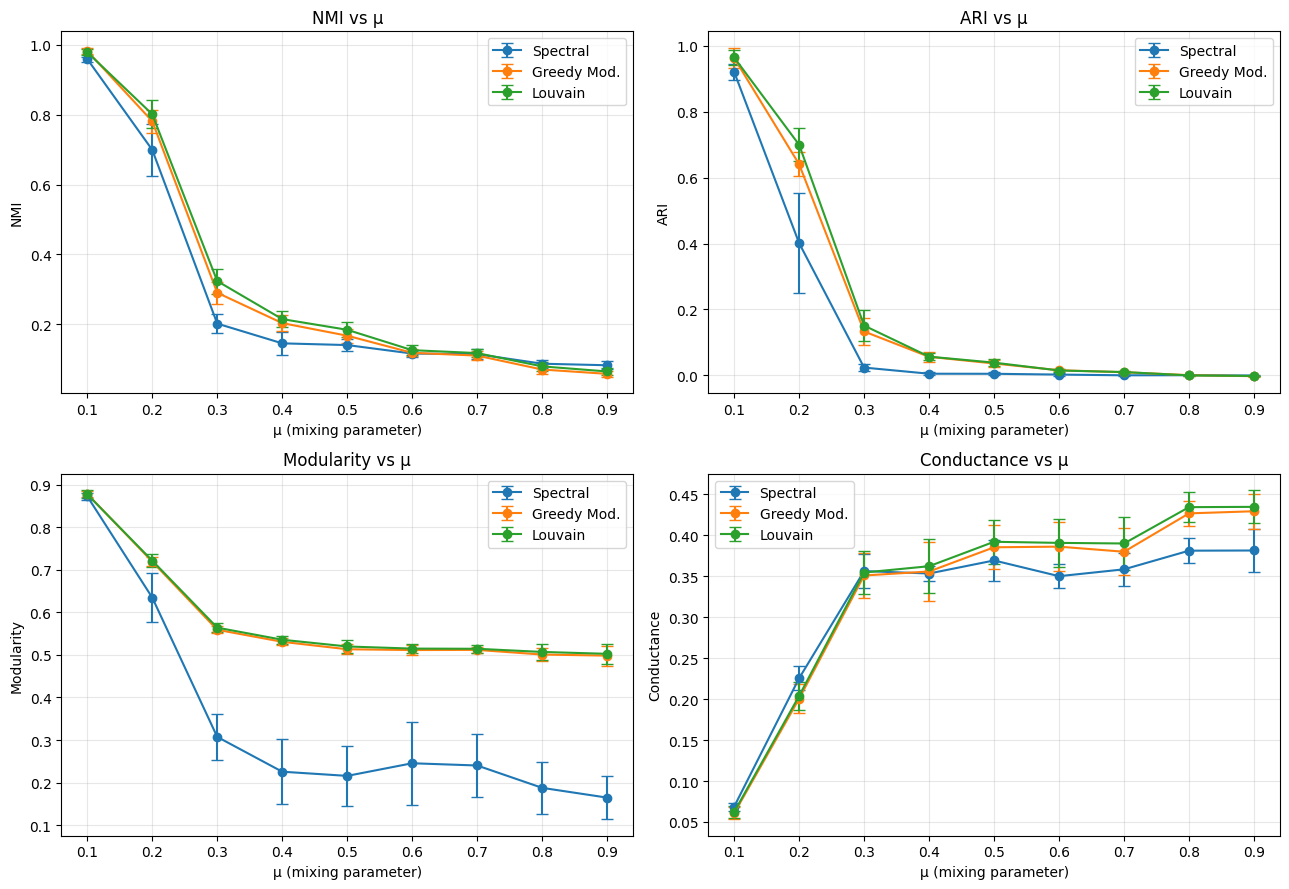

In [24]:
# === Q3 parts (a) & (b): LFR synthetic graphs + algorithm evaluation ===

# (a) generate LFR benchmark graphs with varying mixing parameter mu
mu_range = np.round(np.linspace(0.1, 0.9, 9), 2)
n_realizations = 10

lfr_graphs = []  # flat list of (mu, run_index, graph, ground_truth_dict)

for mu in mu_range:
    for r in range(n_realizations):
        try:
            G_lfr = nx.generators.community.LFR_benchmark_graph(
                n=1000, tau1=3, tau2=1.5, mu=mu,
                average_degree=5, max_degree=100,
                min_community=20, max_community=100,
                seed=r * 100 + int(mu * 100),
                tol=1e-3, max_iters=1000
            )
            # ground truth: each node has a frozenset 'community' attribute
            gt = {nd: min(G_lfr.nodes[nd]['community']) for nd in G_lfr.nodes()}
            lfr_graphs.append((mu, r, G_lfr, gt))
            print(f"  LFR mu={mu:.1f} run {r+1}/{n_realizations} OK")
        except Exception as exc:
            print(f"  LFR mu={mu:.1f} run {r+1}/{n_realizations} FAILED: {exc}")

print(f"\nGenerated {len(lfr_graphs)} LFR graphs")

# (b) run the three algorithms on every synthetic graph and record metrics
synth_rows = []

for mu, r, G_lfr, gt in lfr_graphs:
    n_comms = max(len(set(gt.values())), 2)

    # spectral needs a connected graph
    if nx.is_connected(G_lfr):
        G_conn = G_lfr
    else:
        G_conn = G_lfr.subgraph(max(nx.connected_components(G_lfr), key=len)).copy()

    algo_results = {
        'Spectral': spectral_partition(G_conn, n_comms),
        'Greedy Mod.': greedy_partition(G_lfr),
        'Louvain': louvain_partition(G_lfr),
    }

    for aname, part in algo_results.items():
        # backfill nodes not in LCC for spectral
        part = {nd: part.get(nd, -1) for nd in G_lfr.nodes()}

        mod = modularity_score(G_lfr, part)
        cond = avg_conductance(G_lfr, part)

        nodes_with_gt = [n for n in part if n in gt]
        y_pred = [part[n] for n in nodes_with_gt]
        y_true = [gt[n] for n in nodes_with_gt]
        nmi = normalized_mutual_info_score(y_true, y_pred)
        ari = adjusted_rand_score(y_true, y_pred)

        synth_rows.append({
            'mu': mu, 'run': r, 'Algorithm': aname,
            'Modularity': mod, 'Conductance': cond, 'NMI': nmi, 'ARI': ari
        })

    print(f"  Evaluated mu={mu:.1f} run {r+1}")

synth_df = pd.DataFrame(synth_rows)

# plot NMI, ARI, Modularity, Conductance vs mu with error bars
fig, axes = plt.subplots(2, 2, figsize=(13, 9))

for ax, metric in zip(axes.ravel(), ['NMI', 'ARI', 'Modularity', 'Conductance']):
    for algo in ['Spectral', 'Greedy Mod.', 'Louvain']:
        subset = synth_df[synth_df['Algorithm'] == algo]
        grouped = subset.groupby('mu')[metric]
        mu_means = grouped.mean()
        mu_stds = grouped.std()
        ax.errorbar(mu_means.index, mu_means.values, yerr=mu_stds.values,
                    label=algo, marker='o', capsize=4)
    ax.set_xlabel('μ (mixing parameter)')
    ax.set_ylabel(metric)
    ax.set_title(f'{metric} vs μ')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [25]:
# === Q3 part (c): Compare average Modularity & Conductance across dataset categories ===

# categorize the real datasets from eval_df (computed in 2c)
classic_names = {fname.split('.')[0] for fname in classic_graphs.keys()}
labeled_names = {'citeseer', 'cora', 'pubmed'}

rc_mask = eval_df['Dataset'].isin(classic_names)
rl_mask = eval_df['Dataset'].isin(labeled_names)

# eval_df may have string '—' for missing metrics, so coerce to numeric
numeric_cols = ['Modularity', 'Conductance']
avg_rc = eval_df.loc[rc_mask, numeric_cols].apply(pd.to_numeric, errors='coerce').mean()
avg_rl = eval_df.loc[rl_mask, numeric_cols].apply(pd.to_numeric, errors='coerce').mean()
avg_syn = synth_df[numeric_cols].mean()

comparison_df = pd.DataFrame({
    'Real-Classic': avg_rc,
    'Real-Node-Label': avg_rl,
    'Synthetic (LFR)': avg_syn,
}).T

print("Average Modularity & Conductance by dataset category:\n")
print(comparison_df.to_string())

Average Modularity & Conductance by dataset category:

                 Modularity  Conductance
Real-Classic       0.452907     0.242740
Real-Node-Label    0.633489     0.052256
Synthetic (LFR)    0.502591     0.327653


## 4. [Bonus] Compare the results with an algorithm published/proposed in the last 4 years and report your observations [10%]

## 5. [Bonus] Compare the results on 3 more real world datasets not included in the assignment and report your observations [10%]